**DSCI 100 Group Project Report**

*Antarip Kashyap, Bryan Wong, William Kendrick, Anthony Vu*

**Introduction**

In recent years, researchers have documented that video game sales have skyrocketed due to both increased internet access and better living conditions[1]. However, certain video games significantly outperform others in these sales numbers, speculated to be due to the critic and user scores reported on these games.

To look further into this conjecture, we need to understand the difference between the critic score and the user score of a video game. A critic is someone who professionally judges the merits of the video game in its ability to target multiple elements of customer retention, such as how the game lives up to preview footage, identifying glitches or bugs, the visual aspects of the game, the replayability, the story, etc. There is no standard for a critic score, so it is often weighted by what the critic believes makes a good game. These critic reviews are then compiled and averaged into a single critic score. On the other hand, the user can be anyone who has played the game; then, they provide a user score composed of critical aspects used by critics or an arbitrary rating from the user. The user score is compiled across thousands and thousands of user reviews into a single overall score[2].

So the question we would formulate to delve into this further would be, "How does the critic and user score of a video game affect its global sales?"

The dataset used in this report is from Kaggle, containing data for over 13,000 games collected from VGChartz. The author created this dataset with the intent to answer, "Are video games getting worse?" which, as a result, led to the collection of user and critic scores. We picked this dataset to answer our research question as it was one of the only datasets to include both the user and critic scores for each game.

**Methods**

For our project, we will analyze the relationship between sales volume and a game's given user & critic review score.

The main variables we will use to compare here are Critic_Score, User_Score, and Total_Shipped.

All the variables are of type double.

Firstly, we wrangled and cleaned our data by removing observations without a critic or a user score. Furthermore, we classified all data points for Total_Shipped that fall 3 standard deviations above the average as an outlier and removed such observations. We do this because any data point that falls far away from the cluster of points is clearly not representative of the majority of the data points present here. We use three standard deviations specifically because it is the standard used (in UBC STATS and in multiple data science projects) to determine for boxplots what points would be classified as an outlier. Hence, in our case, we will also be using that standard to classify our outliers.

On top of our data set, we provided a mutated column called "Weighted_Score" that provides an average score if we were given both a critic and user score. Some cases are such that either Critic or User scores are NA, in which case we will have to work with the present score to include as much data as possible.

In [1]:
### Loading necessary libraries.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#reading the data from the raw link from the github repository
videogame <- read_csv(url("https://raw.githubusercontent.com/antaripJKashyap/DSCI100_proj/main/game_sales_data.csv"))
videogame

Rows: 19600 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Name, Platform, Publisher, Developer
dbl (5): Rank, Critic_Score, User_Score, Total_Shipped, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rank,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Wii Sports,Wii,Nintendo,Nintendo EAD,7.7,8.0,82.90,2006
2,Super Mario Bros.,NES,Nintendo,Nintendo EAD,10.0,8.2,40.24,1985
3,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,8.0,7.5,40.00,2012
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19596,Ashita no Joe 2: The Anime Super Remix,PS2,Capcom,Capcom,NA,NA,0.01,2002
19597,Tokyo Yamanote Boys for V: Main Disc,PSV,Rejet,Rejet,NA,NA,0.01,2017
19598,NadePro!! Kisama no Seiyuu Yatte Miro!,PS2,GungHo,GungHo Works,NA,NA,0.01,2009


In [3]:
#tidying the data to display predictive capabilities

outlier_limit <- mean(videogame$Total_Shipped) + 3 * sd(videogame$Total_Shipped)
outlier_limit

videogame_combined <- videogame |>
    group_by(Critic_Score, User_Score) |>
    mutate(Weighted_Score = ifelse(!is.na(User_Score) && !is.na(Critic_Score), ((User_Score + Critic_Score)/2), 
        ifelse(is.na(User_Score) && !is.na(Critic_Score), Critic_Score, 
            ifelse(!is.na(User_Score) && is.na(Critic_Score), User_Score, NA)))) |>
    filter(Total_Shipped < outlier_limit) |>
    filter(!is.na(Weighted_Score)) |>
    select(Name, Total_Shipped, Critic_Score, User_Score, Weighted_Score)
videogame_combined

[1] 5.565521

Name,Total_Shipped,Critic_Score,User_Score,Weighted_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Super Smash Bros.,5.55,8.4,NA,8.4
Assassin's Creed,5.55,8.2,8,8.1
Batman: Arkham City,5.54,9.6,NA,9.6
⋮,⋮,⋮,⋮,⋮
Nancy Drew: The Deadly Secret of Olde World Park,0.01,7.0,NA,7.0
Donkey Kong,0.01,8.5,NA,8.5
Tom Clancy's Splinter Cell,0.01,9.4,NA,9.4


Next, we split our dataset into a training and testing set, which is important when evaluating the trustworthiness of our regression model. The training split will be used to train our KNN model, and the testing split can then be used to test how accurate our model truly is.

In [4]:
#splitting data into training and testing with the training split having 75% of the data
set.seed(1)
videogame_split <- initial_split(videogame_combined, prop= 0.75, strata= Weighted_Score)
videogame_train <- training(videogame_split)
videogame_test <- testing(videogame_split)

First, we want to confirm that the Weighted score is an appropriate predictor to use. To do so, we will use the ggpairs function to determine its viability. The ggpairs diagram produced below shows the appropriate correlations between the predictors.

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 11 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5733 rows containing missing values”
Warning message:
“Removed 11 rows containing missing values (geom_point).”
Warning message:
“Removed 11 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5744 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 11 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 11 rows containing missing values”
Warning message:
“Removed 5733 rows containing missing values (geom_point).”
Warning message:
“Removed 5744 rows containing missing values (geom_point).”
Warning message:
“Removed 5733 rows contai

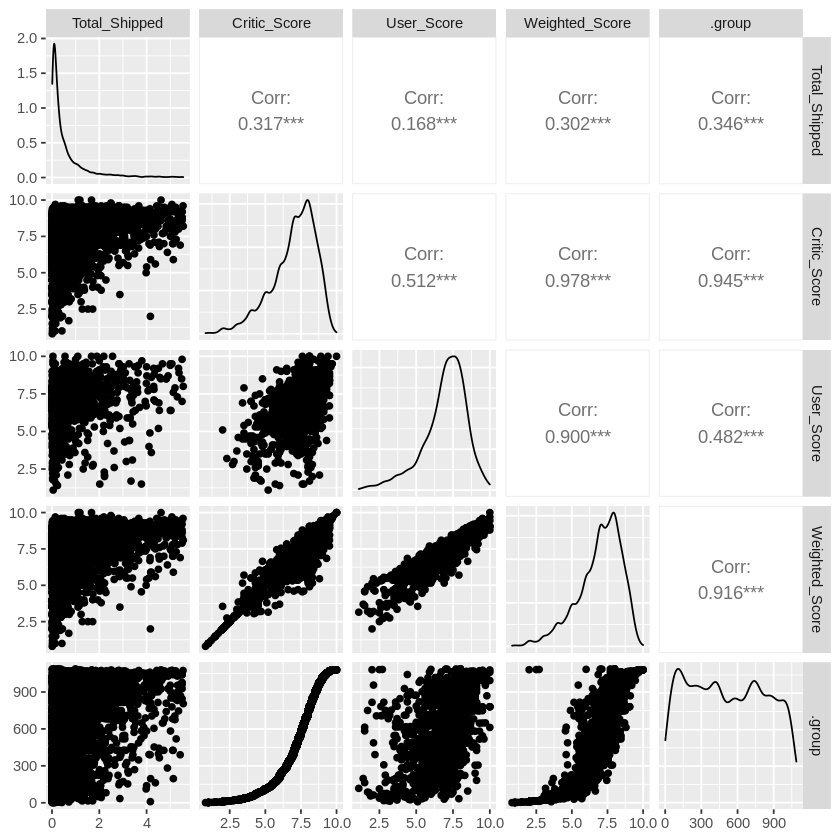

In [5]:
videogame_eda <- videogame_train |>
      select(-Name) |>
      ggpairs()
videogame_eda

     Name           Total_Shipped     Critic_Score      User_Score    
 Length:7330        Min.   :0.0100   Min.   : 0.800   Min.   : 1.100  
 Class :character   1st Qu.:0.1000   1st Qu.: 6.100   1st Qu.: 6.200  
 Mode  :character   Median :0.2600   Median : 7.300   Median : 7.200  
                    Mean   :0.6038   Mean   : 7.003   Mean   : 6.946  
                    3rd Qu.:0.7100   3rd Qu.: 8.100   3rd Qu.: 8.000  
                    Max.   :5.5500   Max.   :10.000   Max.   :10.000  
                                     NA's   :11       NA's   :5733    
 Weighted_Score  
 Min.   : 0.800  
 1st Qu.: 6.050  
 Median : 7.200  
 Mean   : 6.952  
 3rd Qu.: 8.000  
 Max.   :10.000  
                 

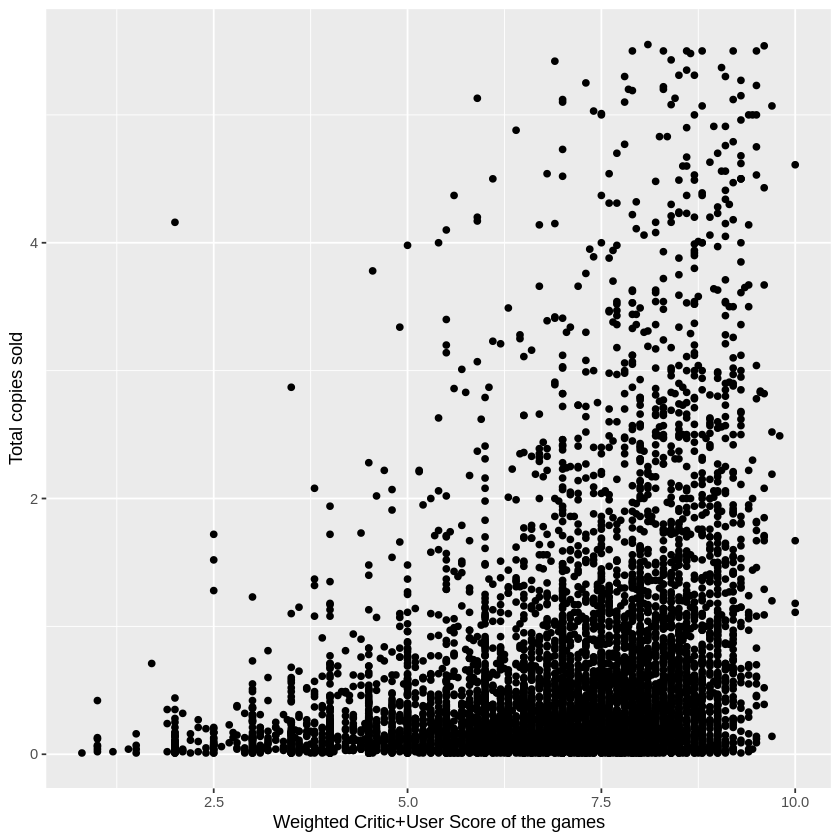

In [6]:
videogame_plot <- ggplot(videogame_train, aes(x= Weighted_Score, y= Total_Shipped)) +
geom_point() + labs(x= "Weighted Critic+User Score of the games", y= "Total copies sold")
videogame_plot
summary(videogame_train)

From the training data plot-
- Sales volume and user & critic review scores are numerical variables. 
- The distribution of Total_Shipped points follows a left-skewed pattern with a mean of 0.6038, suggesting an increasing rate of Total Copies Sold as the rating increases. 
- We can see clearly from this plot that the data has a positive relationship. However, this relationship is not linear at all. We can almost certainly quantify this as an exponential positive relationship as we see that the gradient of any perceived "line of best fit" will continually increase.
- This non-linear relationship suggests that fitting a KNN regression model rather than a linear one would be appropriate.

We will create the KNN model using the nearest_neighbor function but find the optimal K value first.

In [ ]:
#training, evaluating and tuning the knn model
set.seed(1)
videogame_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

videogame_recipe <- recipe(Total_Shipped ~ Weighted_Score, data = videogame_train) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

videogame_vfold <- vfold_cv(videogame_train, v = 5, strata = Weighted_Score)

videogame_workflow <- workflow() |>
  add_recipe(videogame_recipe) |>
  add_model(videogame_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 300, by = 5))

videogame_results <- videogame_workflow |>
  tune_grid(resamples = videogame_vfold, grid = gridvals) |>
  collect_metrics() 

videogame_min <- videogame_results |>
    filter(.metric == "rmse") |>
    arrange(.metric) |> 
    filter(mean == min(mean))

k_min <- videogame_min |>
    pull(neighbors)
k_min

In [ ]:
k_val_plot <- videogame_results |>
    ggplot(aes(x= neighbors, y= mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Mean RMSE") +
    ggtitle("RMSE vs K value")
k_val_plot

To fit a KNN regression model, we first set up our regression specification and KNN recipe while stepping and scaling our predictors to ensure it is standardized before fitting. We will also tune our regression to find the optimal k value.

To do so, we perform 5-fold cross-validation, form our recipe workflow, create our tuning grid and collect the metrics to find the optimal k value. Our code shows that k = 281 has the lowest RMSE from a k range of 1-300, with skips of 4. Next, we set up our regression specification and KNN recipe of k = 281.

In [ ]:
#we run KNN regression with 281 nearest neighbours
set.seed(1)
videogame_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

videogame_best_fit <- workflow() |>
         add_recipe(videogame_recipe) |>
         add_model(videogame_best_spec) |>
         fit(data = videogame_train)

In [ ]:
#Graph of predicted sales based off of the weighted score (average of critic/user scores) (blue line) 
set.seed(1)
options(repr.plot.width = 10, repr.plot.height = 10)

videogame_preds <- videogame_best_fit |>
          predict(videogame_train) |>
          bind_cols(videogame_train)

videogame_plot <-  
        ggplot(videogame_preds, aes(x = Weighted_Score, y = Total_Shipped)) + 
        geom_point() +
        geom_line(data = videogame_preds, 
            mapping = aes(x = Weighted_Score, y = .pred), 
            color = "blue") +
        xlab("Weighted Critic+User Score") +
        ylab("Total Units Shipped") + 
        ggtitle("Total Units Shipped vs Weighted Critic+User Score") +
        theme(text = element_text(size = 20))
                  
videogame_plot

Now that we have generated our KNN model and plotted it as per our training data, we would like to see how the model performs with the data it has yet to be trained on.

The central aspect we want to judge for our KNN model is the RMSPE score which is the root mean square percentage error. This value will tell us how accurate our KNN model is when we apply it to a real-world scenario with data it will not have encountered before.

In [ ]:
#performing RSMPE
set.seed(1)
vg_rmspe <- videogame_best_fit |>
        predict(videogame_test) |>
        bind_cols(videogame_test) |>
        metrics(truth = Total_Shipped, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()
vg_rmspe

The above-obtained value for our RMSPE is very close to 1. Although we would want the number for the RMSPE to be as low as possible, this number doesn't tell us very much unless perhaps we compare it to our RMSE generated by comparing it with our training data

We will also do an RMSE to compare how close the two values are to each other.

In [ ]:
set.seed(1)
vg_rmse <- videogame_best_fit |>
        predict(videogame_train) |>
        bind_cols(videogame_train) |>
        metrics(truth = Total_Shipped, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()
vg_rmse

We can see now that the RMSPE and RMSE values are incredibly close. These values indicate that the model is as good a fit for the testing data as it is for the training data. As a result, the data trends we see with our training data are likely also present within the testing data.

We can make this assertion because if those trends did not exist in the testing data, then some of the points would have been way closer or further than the KNN regression line, thus producing either a far lower or far higher RMSE value, respectively.

Therefore, this model is as good a fit as we can get for this dataset for all K values below 300.

**Discussion**


As we can see from our KNN fit visualization, we can see a sizable uptick in the total units shipped as the average critic score increases past the 7/10 mark. Before this, there was a steady increase in the units shipped up until the score of about 5.5/10. Between the ratings of 5.5 and 7.0, we see a slight dip in the total units shipped, which is contrary to the prior and following ratings. Past the 9/10 point, we see the trend plateau, with no dips or increases. This could be explained by the very low number of points that are available past this range.

Overall we expected to see a clear positive correlation. In particular, the expectation was to find a significant increase in the total units shipped for games with ratings higher than 6.0/10. We expect this because the consumers would perceive a game as a decently made project once reviewers provide such a rating. The perceived confidence would cause a greater consumer demand for the game, causing a rise in the total units shipped to fulfill such a demand. For the most part, our data follows this trend when applied to our KNN fit. It only disobeys this principle in between the interval mentioned above.

Such findings help game developers to decide how many hard copies of their games would be ideal for shipping to sellers depending on preliminary critic scores based on the trend produced by our KNN fit model. This data would ensure game developers can match consumer demand for their project while minimizing production costs and wastage of raw materials caused by the production of excessive hard copies of games.

One obvious question to ask as a result of our analysis would be why the results do not fit the rest of the model's trends in between the ratings of 5.5 and 7.0. Further analysis would include what amount of the total demand for a video game project is a result of the critic score and what fraction of the demand is a result of the popularity of the project, the marketing campaign, and the popularity of the developers themselves. The above analysis may explain the sudden change in trends between the 5.5 and 7.0 intervals.


**References to relevant literature in APA style**

*Literature used, presented for further reading*

[1]- Selnow, G. (1987). The fall and rise of video games. Journal of Popular Culture, 21(1), 53.

[2]- Cox, J., & Kaimann, D. (2015). How do reviews from professional critics interact with other signals of product quality? Evidence from the video game industry. Journal of Consumer Behaviour, 14(6), 366-377.

*Dataset used*

Holm, J. (2021, August 16). Video game sales data. Kaggle. Retrieved December 6, 2022, from https://www.kaggle.com/datasets/holmjason2/videogamedata 

VGChartz. (n.d.). Video game charts, game sales, top sellers, game data. VGChartz. Retrieved August 16, 2021, from https://www.vgchartz.com/gamedb/ 

